In [1]:
#LIBRERÍAS UTILIZADAS (para descomentar si no se tiene):
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn
# %pip install xgboost

In [2]:
import pandas as pd
import numpy as np

# Ruta del archivo
file_path = ''

# Cargar el dataset
df = pd.read_csv(file_path+'dataset_shots.csv')

# Información del dataset
print(f'Cantidad de filas: {df.shape[0]}')
print(f'Cantidad de columnas: {df.shape[1]}')

# Identificar columnas numéricas y categóricas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

print(f'Columnas numéricas: {numerical_cols}')
print(f'Columnas categóricas: {categorical_cols}')

# Verificar valores vacíos
missing_values = df.isnull().sum()
print(f'Valores vacíos:\n{missing_values}')


# Estadísticas descriptivas solo para columnas relevantes
relevant_numerical_cols = ['start_x', 'start_y', 'minute', 'blocked_x', 'blocked_y']
descriptive_stats = df[relevant_numerical_cols].describe()
print(f'Estadísticas descriptivas:\n{descriptive_stats}')

# Valores únicos por columna
unique_values = df.nunique()
print(f'Valores únicos por columna:\n{unique_values}')

Cantidad de filas: 68194
Cantidad de columnas: 25
Columnas numéricas: Index(['Unnamed: 0', 'id', 'start_x', 'start_y', 'minute', 'end_x', 'end_y',
       'blocked_x', 'blocked_y', 'is_own_goal', 'match_id'],
      dtype='object')
Columnas categóricas: Index(['shot_outcome', 'player', 'date', 'area', 'from_throw_in', 'shot_type',
       'from_corner', 'from_freekick', 'from_open_play', 'from_fastbreak',
       'from_penalty', 'from_setpiece', 'from_cross_open_play',
       'shot_on_post'],
      dtype='object')
Valores vacíos:
Unnamed: 0                  0
id                          0
start_x                    30
start_y                    30
minute                      0
end_x                   68194
end_y                   68194
blocked_x               32419
blocked_y               32419
shot_outcome                0
player                   4604
is_own_goal             68023
match_id                53292
date                    53292
area                        0
from_throw_in     

C:\Users\Agus\AppData\Local\Temp\ipykernel_8628\3184055249.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path+'dataset_shots.csv')


In [3]:
#Limpieza de dataset

duplicated_ids = df[df.duplicated('id', keep=False)]
duplicated_ids = duplicated_ids[['id', 'player']].sort_values(by='id')

print(f'Valores duplicados en la columna id asociados a los jugadores:\n{duplicated_ids}')

# Verificar duplicados por 'id' y agruparlos manteniendo información relevante
def resolve_duplicates(group):
    if group['player'].notnull().any():
        group['player'] = group['player'].fillna(method='bfill').fillna(method='ffill')
    return group.iloc[0]

df = df.groupby('id').apply(resolve_duplicates).reset_index(drop=True)

# Eliminar registros donde 'shot_outcome' es 'Successful'
df = df[df['shot_outcome'] != 'Successful']
print(f'Cantidad de registros después de eliminar: {df.shape[0]}')

C:\Users\Agus\AppData\Local\Temp\ipykernel_8628\4270679174.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group['player'] = group['player'].fillna(method='bfill').fillna(method='ffill')


Valores duplicados en la columna id asociados a los jugadores:
                 id          player
40664  2.311100e+09     Alan Varela
45268  2.311100e+09             NaN
40665  2.311100e+09  Agustín Obando
45269  2.311100e+09             NaN
40666  2.311100e+09     Alan Varela
...             ...             ...
45265  2.340768e+09   Brian Aguirre
49869  2.340770e+09             NaN
45266  2.340770e+09      José López
45267  2.340771e+09  Cristian Pavón
49870  2.340771e+09             NaN

[9200 rows x 2 columns]
Cantidad de registros después de eliminar: 63403


In [4]:

print(f'Cantidad de filas: {df.shape[0]}')
#Eliminación de columnas completamente vacías
df.drop(columns=['end_x', 'end_y'], inplace=True)

# Calcular el ángulo del disparo contra el arco
# Tip: np.arctan(7.32 * coordenada_x / (coordenada_x**2 + coordenada_y**2 - (7.32/2)**2))
df['angulo_de_tiro'] = np.arctan(7.32 * df['start_x'] / (df['start_x']**2 + df['start_y']**2 - (7.32/2)**2))

# Calcular la distancia del disparo al arco
# Tip 2: El centro del arco está en x=100 e y=50
df['distancia_de_tiro'] = np.sqrt((100 - df['start_x'])**2 + (50 - df['start_y'])**2)

# Mostrar las primeras filas del dataset para verificar las nuevas columnas
print(df.head())


Cantidad de filas: 63403
   Unnamed: 0        id  start_x  start_y  minute  blocked_x  blocked_y  \
0        6873  112083.0     78.5     23.7    43.0        NaN        NaN   
1        7848  353508.0     72.1     38.6    80.0        NaN        NaN   
2        6824  400339.0     90.4     34.2    57.0       97.3       47.1   
3        8602  767448.0     91.6     37.3    14.0       95.9       53.6   
4        1143  775499.0     83.1     53.2    84.0        NaN        NaN   

  shot_outcome           player  is_own_goal  ...  from_corner from_freekick  \
0  MissedShots    Pablo Rosales          NaN  ...        False         False   
1  MissedShots   Maxi Rodríguez          NaN  ...        False         False   
2  MissedShots    Fernando Luna          NaN  ...        False         False   
3  MissedShots  Sergio González          NaN  ...         True         False   
4  MissedShots     Óscar Romero          NaN  ...        False         False   

  from_open_play  from_fastbreak from_penal

In [5]:
# Guardar el dataset con las nuevas columnas
output_file_path = file_path+'dataset_shots_with_angles_distances.csv'
df.to_csv(output_file_path, index=False)
print(f'Dataset con nuevas columnas guardado en: {output_file_path}')

Dataset con nuevas columnas guardado en: dataset_shots_with_angles_distances.csv


In [6]:
#Dividir el dataset en tiros que no resultaron en gol en contra
df = pd.read_csv(file_path+'dataset_shots_with_angles_distances.csv')
dataset_a_favor = df[df['is_own_goal']!=1.0]
dataset_en_contra = df[df['is_own_goal']==1.0]

dataset_a_favor.to_csv(file_path+'dataset_a_favor.csv', index=False)
dataset_en_contra.to_csv(file_path+'dataset_en_contra.csv', index=False)

C:\Users\Agus\AppData\Local\Temp\ipykernel_8628\1386332007.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path+'dataset_shots_with_angles_distances.csv')


C:\Users\Agus\AppData\Local\Temp\ipykernel_8628\2871235446.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ang_dist = pd.read_csv(file_path+'dataset_a_favor.csv')


Promedio de la distancia de los disparos: 21.02983109976359
Mediana de la distancia de los disparos: 20.856893344887204
Cantidad de disparos por área:
area
Outside of the box    28225
Penalty box           31541
Six yard box           3481
dtype: int64
Cantidad de goles por área:
area
Outside of the box     842
Penalty box           3795
Six yard box          1132
dtype: int64
Porcentaje de goles por área:
area
Outside of the box     2.983171
Penalty box           12.031958
Six yard box          32.519391
dtype: float64
Cantidad de goles en contra: 0


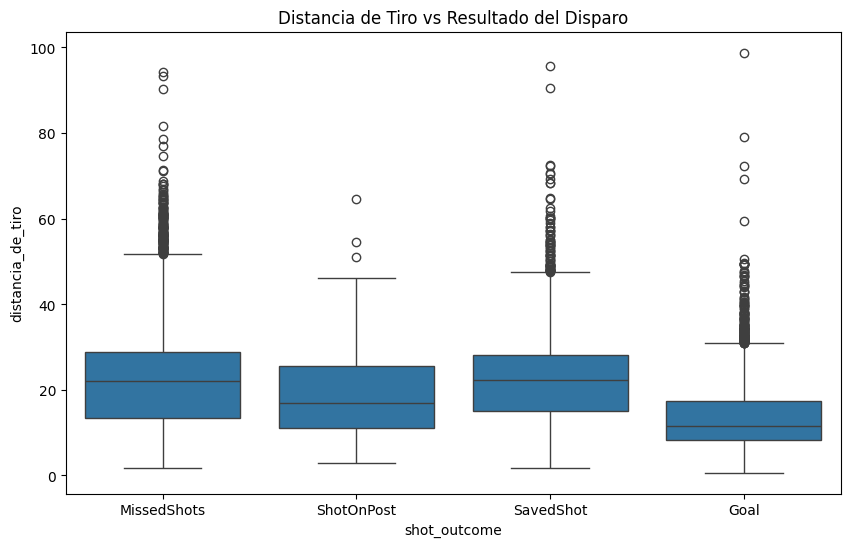

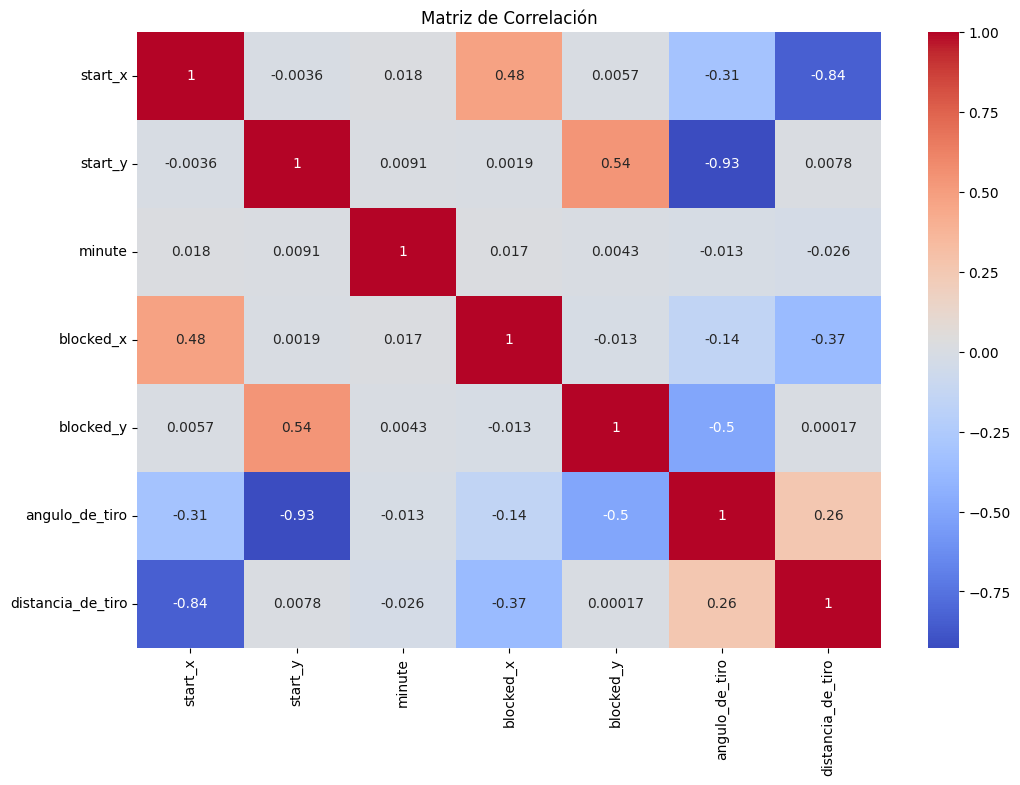

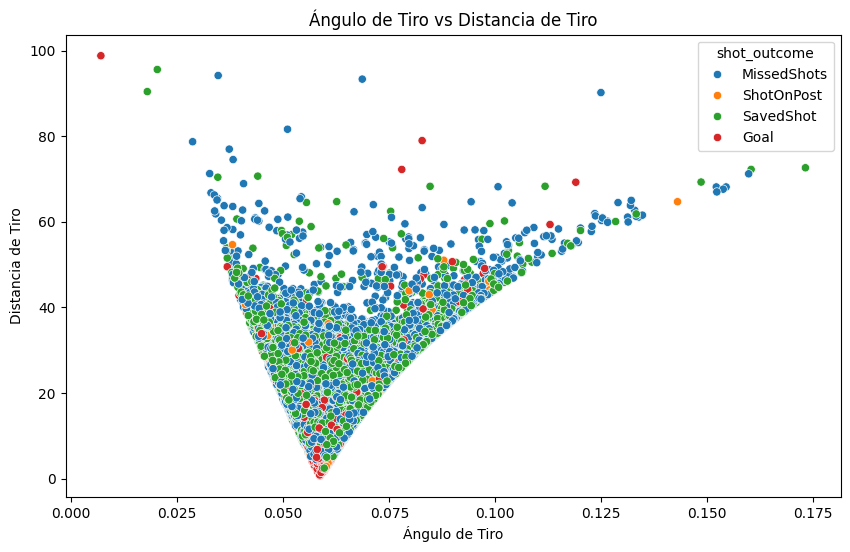

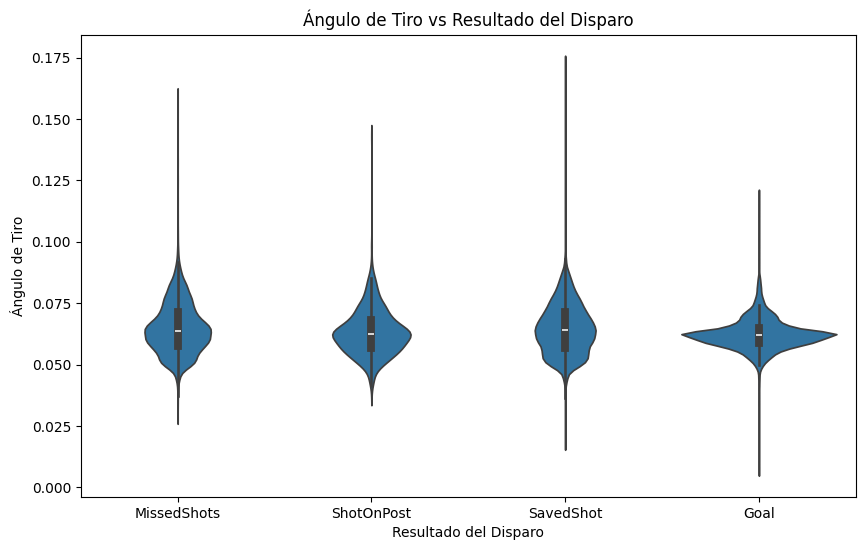

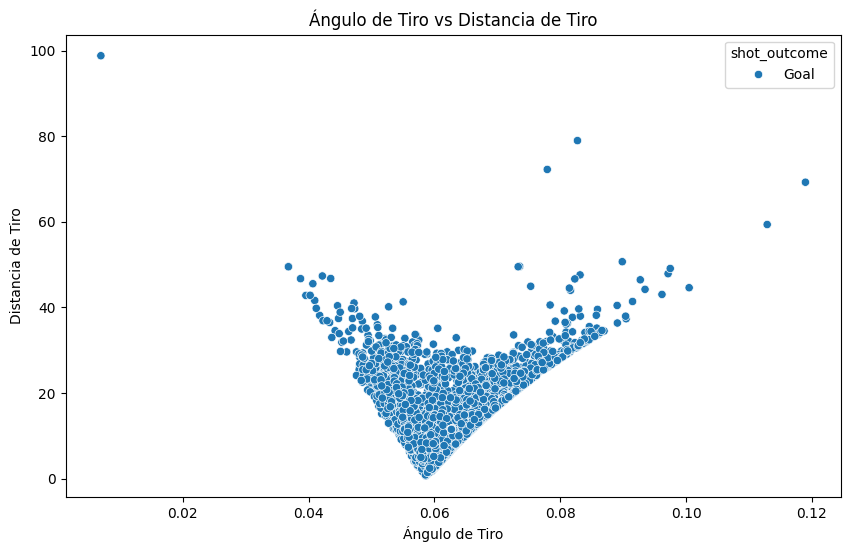

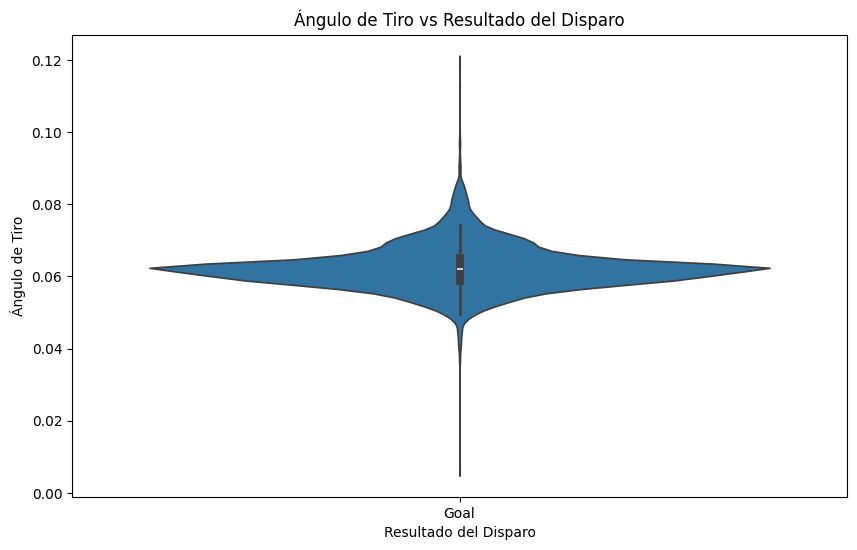

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df_ang_dist = pd.read_csv(file_path+'dataset_a_favor.csv')

# Promedio y Mediana de la Distancia de los Disparos
promedio_distancia = df_ang_dist['distancia_de_tiro'].mean()
mediana_distancia = df_ang_dist['distancia_de_tiro'].median()

print(f'Promedio de la distancia de los disparos: {promedio_distancia}')
print(f'Mediana de la distancia de los disparos: {mediana_distancia}')

# Disparos en el Área Chica, Área Grande y Fuera del Área
disparos_area = df_ang_dist.groupby('area').size()
goles_area = df_ang_dist[df_ang_dist['shot_outcome'] == 'Goal'].groupby('area').size()
porcentaje_goles_area = (goles_area / disparos_area) * 100

print(f'Cantidad de disparos por área:\n{disparos_area}')
print(f'Cantidad de goles por área:\n{goles_area}')
print(f'Porcentaje de goles por área:\n{porcentaje_goles_area}')

# Análisis de Goles en Contra
goles_en_contra = df_ang_dist[df_ang_dist['is_own_goal'] == 1].shape[0]
print(f'Cantidad de goles en contra: {goles_en_contra}')

# Visualización del Impacto de una Variable en el Resultado Y
plt.figure(figsize=(10, 6))
sns.boxplot(x='shot_outcome', y='distancia_de_tiro', data=df_ang_dist)
plt.title('Distancia de Tiro vs Resultado del Disparo')
plt.show()

# Correlación entre Variables
correlation_matrix = df_ang_dist[['start_x', 'start_y', 'minute', 'blocked_x', 'blocked_y', 'angulo_de_tiro', 'distancia_de_tiro']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='angulo_de_tiro', y='distancia_de_tiro', hue='shot_outcome', data=df_ang_dist)
plt.title('Ángulo de Tiro vs Distancia de Tiro')
plt.xlabel('Ángulo de Tiro')
plt.ylabel('Distancia de Tiro')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='shot_outcome', y='angulo_de_tiro', data=df_ang_dist)
plt.title('Ángulo de Tiro vs Resultado del Disparo')
plt.xlabel('Resultado del Disparo')
plt.ylabel('Ángulo de Tiro')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='angulo_de_tiro', y='distancia_de_tiro', hue='shot_outcome', data=df_ang_dist[df_ang_dist['shot_outcome'] == 'Goal'])
plt.title('Ángulo de Tiro vs Distancia de Tiro')
plt.xlabel('Ángulo de Tiro')
plt.ylabel('Distancia de Tiro')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='shot_outcome', y='angulo_de_tiro', data=df_ang_dist[df_ang_dist['shot_outcome'] == 'Goal'])
plt.title('Ángulo de Tiro vs Resultado del Disparo')
plt.xlabel('Resultado del Disparo')
plt.ylabel('Ángulo de Tiro')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, log_loss, matthews_corrcoef

# Cargar los datasets
# Reemplazar con la ruta a los archivos correspondientes
# df_ang_dist = pd.read_csv('ruta/dataset.csv')

# Selección de variables
selected_columns = [
    'start_x', 'start_y', 'minute', 'blocked_x', 'blocked_y',
    'area', 'shot_type', 'from_throw_in', 'from_corner',
    'from_freekick', 'from_open_play', 'from_fastbreak',
    'from_penalty', 'from_setpiece', 'from_cross_open_play',
    'shot_on_post', 'angulo_de_tiro', 'distancia_de_tiro',
    'shot_outcome'
]

# Filtrar columnas seleccionadas
df = df_ang_dist[selected_columns].copy()

# Preparación de variables categóricas y numéricas
categorical_features = ['area', 'shot_type']
numerical_features = [
    'start_x', 'start_y', 'minute', 'blocked_x', 'blocked_y',
    'from_throw_in', 'from_corner', 'from_freekick',
    'from_open_play', 'from_fastbreak', 'from_penalty',
    'from_setpiece', 'from_cross_open_play', 'shot_on_post',
    'angulo_de_tiro', 'distancia_de_tiro'
]

# Convertir la variable de salida 'shot_outcome' en categórica binaria (0 o 1)
df['shot_outcome'] = df['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Imputación de valores faltantes
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Dividir en conjuntos de entrenamiento y prueba
X = df.drop('shot_outcome', axis=1)
y = df['shot_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Imputar valores faltantes en el conjunto de entrenamiento
X_train[numerical_features] = numeric_imputer.fit_transform(X_train[numerical_features])
X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])

# Aplicar los imputadores al conjunto de prueba
X_test[numerical_features] = numeric_imputer.transform(X_test[numerical_features])
X_test[categorical_features] = categorical_imputer.transform(X_test[categorical_features])

# Preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Crear pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicar preprocesamiento
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# KNN --------------------------------------
# Entrenamiento del modelo K-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train)

# Predicciones en el conjunto de prueba
y_pred_knn = knn.predict(X_test_processed)
y_pred_knn_proba = knn.predict_proba(X_test_processed)

# Evaluación del modelo
report = classification_report(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Mostrar resultados
print('------K-NEAREST NEIGHBORS------')
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

# RANDOM FOREST ----------------------------
# Entrenamiento del modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train_processed, y_train)

# Predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test_processed)
y_pred_rf_proba = rf.predict_proba(X_test_processed)

# Evaluación del modelo
report = classification_report(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Mostrar resultados
print('------RANDOM FOREST------')
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

# XGBOOST ------------------------
# Entrenamiento del modelo XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_processed, y_train)

# Predicciones en el conjunto de prueba
y_pred_xgb = xgb.predict(X_test_processed)
y_pred_xgb_proba = xgb.predict_proba(X_test_processed)

# Evaluación del modelo
report = classification_report(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Mostrar resultados
print('------XGBOOST------')
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

------K-NEAREST NEIGHBORS------
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     11484
           1       0.86      0.76      0.81      1166

    accuracy                           0.97     12650
   macro avg       0.92      0.87      0.89     12650
weighted avg       0.96      0.97      0.97     12650

Confusion Matrix:
 [[11336   148]
 [  280   886]]
------RANDOM FOREST------
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     11484
           1       0.91      0.78      0.84      1166

    accuracy                           0.97     12650
   macro avg       0.94      0.88      0.91     12650
weighted avg       0.97      0.97      0.97     12650

Confusion Matrix:
 [[11397    87]
 [  261   905]]


c:\Users\Agus\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [02:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


------XGBOOST------
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     11484
           1       0.93      0.78      0.84      1166

    accuracy                           0.97     12650
   macro avg       0.95      0.88      0.92     12650
weighted avg       0.97      0.97      0.97     12650

Confusion Matrix:
 [[11412    72]
 [  261   905]]


Métricas KNN:
MCC: 0.7887030632776973
Log Loss: 0.6197888956566491
Confusion Matrix: [[11336   148]
 [  280   886]]
AUC-ROC: 0.9195682351401876
Specificity: 0.9871125043538836
Recall: 0.7598627787307033
Precision: 0.8568665377176016
Accuracy: 0.9661660079051383

Métricas Random Forest:
MCC: 0.8270242444890097
Log Loss: 0.19282008801464356
Confusion Matrix: [[11397    87]
 [  261   905]]
AUC-ROC: 0.9606690089515251
Specificity: 0.9924242424242424
Recall: 0.7761578044596913
Precision: 0.9122983870967742
Accuracy: 0.9724901185770751

Métricas XGBoost:
MCC: 0.834228480516908
Log Loss: 0.09295703124969112
Confusion Matrix: [[11412    72]
 [  261   905]]
AUC-ROC: 0.9746489335897569
Specificity: 0.9937304075235109
Recall: 0.7761578044596913
Precision: 0.9263050153531218
Accuracy: 0.9736758893280633


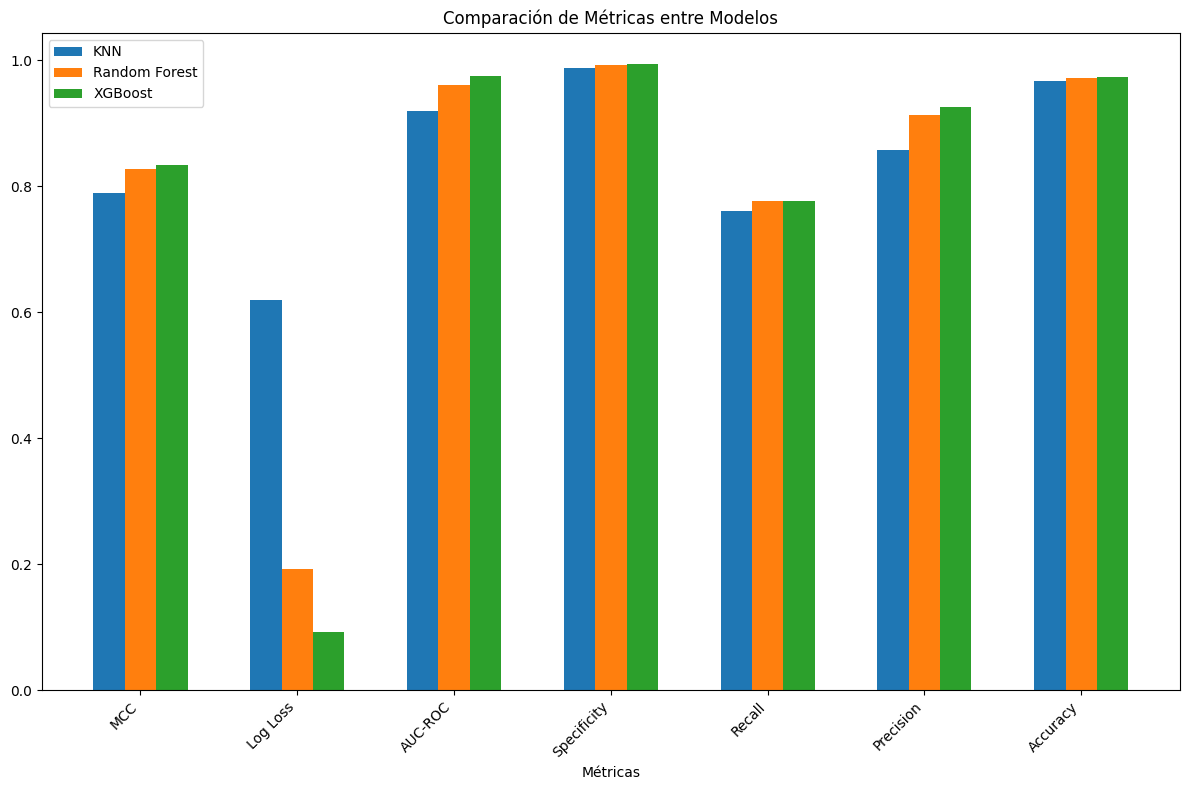

In [9]:
# Función para calcular las métricas
def calculate_metrics(y_true, y_pred, y_pred_proba):
    metrics = {}
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    metrics['Log Loss'] = log_loss(y_true, y_pred_proba)
    metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred)
    metrics['AUC-ROC'] = roc_auc_score(y_true, y_pred_proba[:, 1])
    metrics['Specificity'] = metrics['Confusion Matrix'][0, 0] / (metrics['Confusion Matrix'][0, 0] + metrics['Confusion Matrix'][0, 1])
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    return metrics

# Calcular métricas para cada modelo
metrics_knn = calculate_metrics(y_test, y_pred_knn, y_pred_knn_proba)
metrics_rf = calculate_metrics(y_test, y_pred_rf, y_pred_rf_proba)
metrics_xgb = calculate_metrics(y_test, y_pred_xgb, y_pred_xgb_proba)

# Mostrar resultados
print("Métricas KNN:")
for key, value in metrics_knn.items():
    print(f"{key}: {value}")

print("\nMétricas Random Forest:")
for key, value in metrics_rf.items():
    print(f"{key}: {value}")

print("\nMétricas XGBoost:")
for key, value in metrics_xgb.items():
    print(f"{key}: {value}")

# Función para graficar métricas comparativas
def plot_metrics(metrics_knn, metrics_rf, metrics_xgb):
    # Extraer nombres de las métricas
    metric_names = list(metrics_knn.keys())
    metric_names.remove('Confusion Matrix')  # Excluir matriz de confusión de los gráficos

    # Crear un array para los valores de cada métrica
    knn_values = [metrics_knn[metric] for metric in metric_names]
    rf_values = [metrics_rf[metric] for metric in metric_names]
    xgb_values = [metrics_xgb[metric] for metric in metric_names]

    x = np.arange(len(metric_names))  # La localización de las etiquetas

    width = 0.2  # El ancho de las barras

    fig, ax = plt.subplots(figsize=(12, 8))
    bars_knn = ax.bar(x - width, knn_values, width, label='KNN')
    bars_rf = ax.bar(x, rf_values, width, label='Random Forest')
    bars_xgb = ax.bar(x + width, xgb_values, width, label='XGBoost')

    ax.set_xlabel('Métricas')
    ax.set_title('Comparación de Métricas entre Modelos')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Graficar métricas
plot_metrics(metrics_knn, metrics_rf, metrics_xgb)

In [10]:
# Predecir las probabilidades de gol para el conjunto completo
X_processed = pipeline.transform(X)
goal_probabilities = xgb.predict_proba(X_processed)[:, 1]

# Agregar la columna 'xg' al dataframe original
df['xg'] = goal_probabilities

df_sorted = df.sort_values(by='xg', ascending=False)
# Mostrar los primeros registros para verificar
print(df_sorted.head())

df.to_csv('dataset_xg.csv', index=False)

       start_x  start_y  minute  blocked_x  blocked_y                area  \
37719     78.1     59.4     2.0        NaN        NaN  Outside of the box   
17554     82.2     31.0     1.0       98.5       51.1  Outside of the box   
35982     75.6     47.6     1.0        NaN        NaN  Outside of the box   
56167     79.1     30.7    39.0       85.0       36.6  Outside of the box   
13350     75.6     58.7     1.0       94.1       47.8  Outside of the box   

      shot_type  from_throw_in  from_corner  from_freekick  from_open_play  \
37719      Foot          False        False          False           False   
17554      Foot          False        False          False            True   
35982      Foot          False        False          False            True   
56167      Foot          False        False           True           False   
13350      Foot          False        False          False            True   

       from_fastbreak  from_penalty  from_setpiece  from_cross_open_

C:\Users\Agus\AppData\Local\Temp\ipykernel_8628\3063718391.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Agus\AppData\Local\Temp\ipykernel_8628\3063718391.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


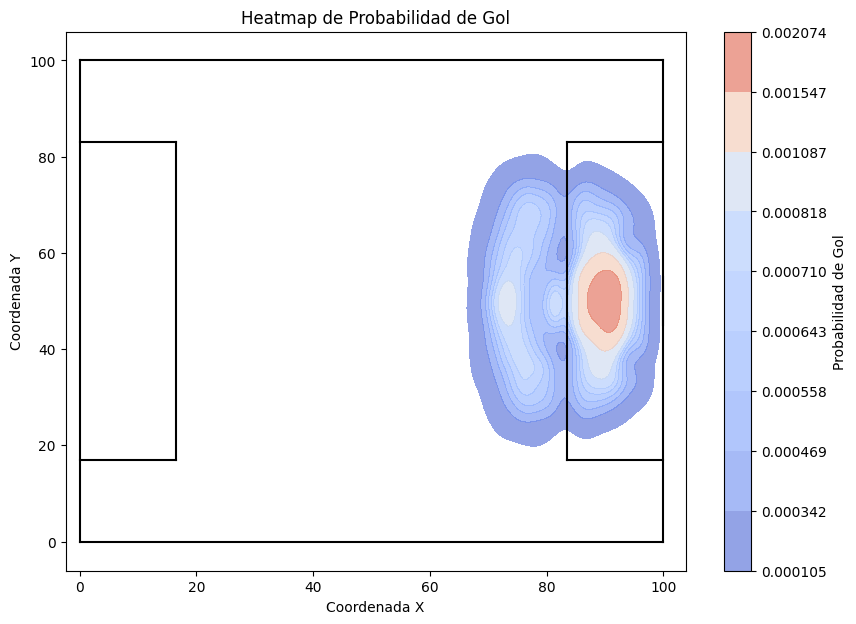

In [11]:
# Crear una figura y un eje para el gráfico
fig, ax = plt.subplots(figsize=(10, 7))

# Dibujar la cancha de fútbol
def draw_pitch(ax=None):
    # Crear el gráfico
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))

    # Cancha
    plt.plot([0, 0], [0, 100], color="black")
    plt.plot([0, 100], [100, 100], color="black")
    plt.plot([100, 100], [100, 0], color="black")
    plt.plot([100, 0], [0, 0], color="black")

    # Área de penal izquierda
    plt.plot([0, 16.5], [83, 83], color="black")
    plt.plot([16.5, 16.5], [83, 17], color="black")
    plt.plot([16.5, 0], [17, 17], color="black")

    # Área de penal derecha
    plt.plot([100, 83.5], [83, 83], color="black")
    plt.plot([83.5, 83.5], [83, 17], color="black")
    plt.plot([83.5, 100], [17, 17], color="black")

    # Arco
    plt.plot([100, 100], [45, 55], color="black")

    return ax

# Dibujar la cancha
ax = draw_pitch(ax)

# Crear el mapa de calor usando seaborn
sns.kdeplot(
    x=df['start_x'],
    y=df['start_y'],
    shade=True,
    shade_lowest=False,
    cmap='coolwarm',
    alpha=0.6,
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Probabilidad de Gol'}
)

# Agregar títulos y etiquetas
ax.set_title('Heatmap de Probabilidad de Gol')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')

# Mostrar el gráfico
plt.show()